In [3]:
import sys
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
#from matplotlib import animation, rc
#from IPython.display import HTML, display # NOTE: will require ffmpeg installation
import numpy as np
import xarray as xr
#import pandas as pd
import geopandas as gpd
import rioxarray
#from shapely.geometry import mapping
from eofs.xarray import Eof
from xeofs.xarray import EOF
#from xarrayutils.utils import linear_trend
import gc
import collections
import statsmodels.api as sm
import scipy
from sklearn.metrics import mean_squared_error
from math import sqrt

In [4]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS

# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'

# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Folder for output figures
figures_folderpath = 'reports/figures/' 

interim_data_folder = 'data/interim/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'
reconstructions_neofs_path = 'reconstructions_neofs/'

In [5]:
flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

# Speed Tests

## xeofs

In [91]:
%%time
model = EOF(flux_clean,n_modes=5)

CPU times: user 3.06 s, sys: 9.43 s, total: 12.5 s
Wall time: 17.8 s


In [92]:
%%time
model.solve()

CPU times: user 4.82 s, sys: 1.22 s, total: 6.03 s
Wall time: 1.15 s


In [93]:
%%time
xeofs_eofs = model.eofs()
xeofs_pcs = model.pcs()

CPU times: user 10.3 ms, sys: 17 ms, total: 27.3 ms
Wall time: 24.2 ms


In [133]:
rec = model.reconstruct_X([1,2,3,4])

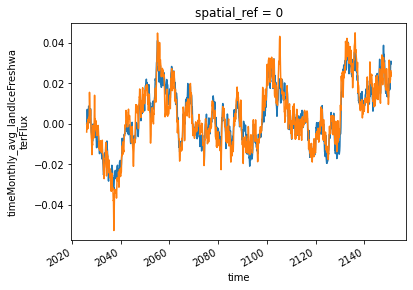

In [134]:
rec.sum(['y','x']).plot()
flux_clean.sum(['y','x']).plot()

CPU times: user 66.1 ms, sys: 8.19 ms, total: 74.3 ms
Wall time: 73.4 ms


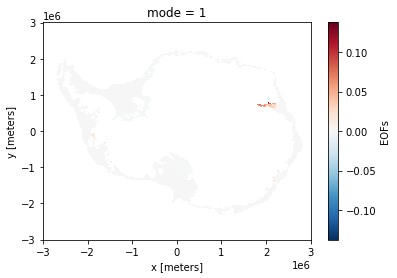

In [100]:
%%time
# Plot a sample mode
xeofs_eofs.isel(mode=0).plot()
# Why does plotting with xeofs take longer? (significantly!)

## eofs

In [7]:
%%time
fluxsolver = Eof(flux_clean)

CPU times: user 2min 28s, sys: 1min 2s, total: 3min 30s
Wall time: 1min 5s


In [14]:
%%time
eofs_eofs = fluxsolver.eofs()
eofs_pcs = fluxsolver.pcs()

CPU times: user 1.05 s, sys: 3.25 s, total: 4.3 s
Wall time: 6.68 s


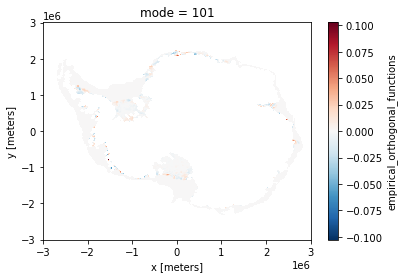

In [26]:
%%time
# Plot a sample mode
eofs_eofs.isel(mode=101).plot()

### Compare xeofs & eofs PC component

Why is there a significant difference between modes here? 
Does xeofs use Extended EOFs, and if so, how does that impact the difference?

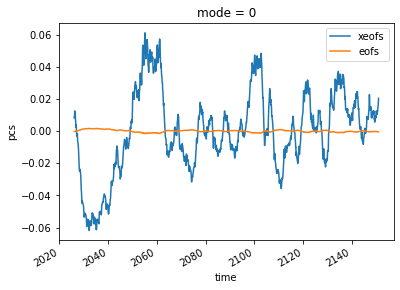

In [113]:
# Compare xeofs and eofs PCs output
xeofs_pcs[:,0].plot(label='xeofs')
(eofs_pcs[:,0]).plot(label='eofs')
plt.legend()

## Phase Randomization
### XEOFs

In [116]:
%%time
##############################
# FOURIER PHASE RANDOMIZATION 
##############################

# Define number of random Fourier realizations
n_realizations = 1
t_length = xeofs_pcs.shape[0]

# fluxpcs[:,i] when using PCA outputs
new_fl = np.empty((n_realizations,xeofs_pcs.shape[0],xeofs_pcs.shape[1]))

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(5):
        fl = xeofs_pcs[:,m] # fluxpcs[:,i] when using PCA outputs
        fl_fourier = np.fft.rfft(fl)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new)
        print('calculated ifft for realization {}'.format(i))
        # plt.plot(new_fl[i,t1:tf],'b', linewidth=0.15) # PLOT LATER! Plotting here adds significant computation time

calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
calculated ifft for realization 0
CPU times: user 5.89 ms, sys: 2.55 ms, total: 8.44 ms
Wall time: 11 ms


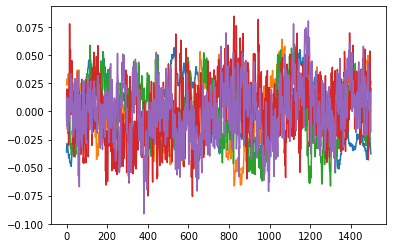

In [124]:
plt.plot(new_fl[0,:])